# Purpose of the notebook

It's a notebook for developing and demonstrating functions for detecting and removing artifacts. Functionality is demonstrated on data from participant 201.

In [2]:
import sys

sys.path.insert(
    1, "..\\utilities\\"
)  # adds utilities folder to path so we can import modules from it, won't be needed after packaging

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import loading_utils as load
import preprocessing_utils as prep

participant_list = [200, 201, 202, 204, 205, 206, 207, 209, 210, 211, 212, 213]
data_dir = './results/new/'

In [3]:
# This is a block for making participant dataframes from raw files in directory data_dir (here Windows path to retinawise mirror folder on drive)
# It saves the participant dfs into directory defined in save_path (about 300 - 400 MB per participant), format 2xx_recording_data.csv
# Uncomment and run if you don't have these dataframes (remember that the folder specified in save_path must exist)
# data_dir = "D:/retinawise_mirror/raw/"
# save_path = './results/'
# for participant_id in participant_list:
#     data_df, protocol_timecourse_df, protocol_vars_df = load.load_participant_data(participant_no=participant_id,
#                                                                                    data_dir=data_dir,
#                                                                                    include_failed=False,
#                                                                                    save=True,
#                                                                                    save_path=save_path)

# General notes

Artifacts can be found through searching for datapoints where pupil size is out of physiological ranges or has a sudden change in value. I will perform this on non-resampled data, since then we will avoid the extreme values being included in bins for resampling. Physiological ranges are between 2 and 8 mm, some sources also give 1.5 - 9 mm, e.g. https://link.springer.com/article/10.3758/s13428-018-1075-y. In accord with this article, measurements outside of this range should be set to NaN.

# Removal of samples outside of physiological range

It's removed based on range of 1.5 - 9 mm. Every sample outside of this range is replaced with NaN. This should be done on data that hasn't been resampled yet, as such artifacts may undergo averaging when data is binned for the resampling procedure. Then they could be flattened and remain undetected later while influencing signal shape.

In [4]:
def remove_non_physio_size(data_df):
    data_df.loc[(data_df['Stim eye - Size Mm']<1.5) | (data_df['Stim eye - Size Mm']>9), 'Stim eye - Size Mm'] = pd.NA
    return data_df

In [5]:
data_dir = "./results/new/"  
data_suffix = "_recording_data.csv" 

data_path = os.path.join(data_dir, str(201) + data_suffix)
data_df = pd.read_csv(data_path)

In [6]:
data_df = remove_non_physio_size(data_df)

In [7]:
data_df[data_df['Stim eye - Size Mm']<1.5]

,Unnamed: 0,Overall time Sec,Sequence time Sec,Experiment state,Sequence index,Sequences count,Excitation index,Excitation label - Left,Excitation label - Right,Left - Is found,...,Filepath,Recording id,Participant id,Block,Test,Trial phase,Trial type,Trial no,Trial time Sec,Stim eye - Size Mm


In [8]:
data_df[data_df['Stim eye - Size Mm']>9]

,Unnamed: 0,Overall time Sec,Sequence time Sec,Experiment state,Sequence index,Sequences count,Excitation index,Excitation label - Left,Excitation label - Right,Left - Is found,...,Filepath,Recording id,Participant id,Block,Test,Trial phase,Trial type,Trial no,Trial time Sec,Stim eye - Size Mm


No rows outside of required range remain.

# MAD velocity artifact detection

For MAD based detection as described here: https://pmc.ncbi.nlm.nih.gov/articles/PMC6538573/, I need to calculate dilation/constriction speed of the pupil. Thanks to that, artifacts related e.g. to blinking can be found through the MAD estimator. In my view, this method should be applied on resampled data - thanks to that the velocity calculation window is constant in sampling time and it avoids the issue when sometimes the time difference between samples was equal to 0, resulting in infinite speed. MAD is calculated as follows:

v - velocity

d - pupil size

s - sampling time

v(t) = max(abs((d(t)-d(t-s))/s),abs((d(t+s)-d(t))/s))

MAD = median(abs(v - median(v)))

threshold = median(v)+n*MAD

n - multiplier deciding on what range of deviation from median we accept, for normal distributions it's about 1.5 for one standard deviation.

Samples with velocity above threshold are replaced with NaN.

I decided to calculate MAD separately for each trial phase, i.e. pre-stimulus, stimulus and post-stimulus, as I expect that each of them will have different ranges of velocity due to response to light and later relaxation from the response.

The advantage of basing artifact detection on pupil velocity is that it captures not only the points where pupil size has already become much larger/smaller than the surroundings, but also the point where the rapid change starts. This way we should avoid having sharp edges remaining around the spike, which would then cause problems with interpolation.


In [9]:
def compute_phase_pupil_speed_mad(resampled_df, multiplier=4.5):
    resampled_df['Pupil velocity'] = pd.Series()
    resampled_df['MAD speed threshold'] = pd.Series()
    resampled_df['Time diff'] = resampled_df['Trial time Sec'].diff()
    resampled_df['Size diff'] = resampled_df['Stim eye - Size Mm'].diff()
    resampled_df.loc[resampled_df['Time diff']<0,'Size diff'] = pd.NA
    resampled_df.loc[resampled_df['Time diff']<0,'Time diff'] = pd.NA
    
    
    
    for trial_no in sorted(resampled_df['Trial no'].unique()):
        trial = resampled_df[resampled_df['Trial no']==trial_no].copy()
        trial['Pupil velocity -1'] = abs(trial['Size diff']/trial['Time diff'])
        trial['Pupil velocity +1']=abs(trial['Size diff'].shift(-1)/trial['Time diff'].shift(-1))
        trial['Pupil velocity']=trial[['Pupil velocity -1','Pupil velocity +1']].max(axis='columns')
        
        for phase in sorted(trial['Trial phase'].unique()):
            
            median = trial['Pupil velocity'][trial['Trial phase']==phase].median()
            mad = (abs(trial['Pupil velocity'][trial['Trial phase']==phase] - median)).median()
            threshold_up = median+multiplier*mad
            
            resampled_df.loc[(resampled_df['Trial no']==trial_no)&(resampled_df['Trial phase']==phase),'MAD speed threshold'] = threshold_up
        resampled_df.loc[(resampled_df['Trial no']==trial_no),'Pupil velocity'] = trial['Pupil velocity']
    
    return resampled_df

In [10]:
def remove_samples_above_speed_MAD(resampled_df,multiplier=4.5):
    mad_df = compute_phase_pupil_speed_mad(resampled_df,multiplier)
    mad_df.loc[mad_df['Pupil velocity'] > mad_df['MAD speed threshold'],'Stim eye - Size Mm'] = pd.NA
    return mad_df

In [11]:
data_dir = "./results/resampled/"  # directory with resampled data
data_suffix = "_nonan_30_resampled_data.csv"  # name of file with 30 Hz resampled data from participant 2xx, name format: 2xxdata_suffix

data_path = os.path.join(data_dir, str(201) + data_suffix)
data_df = pd.read_csv(data_path)

In [12]:
data_df = remove_non_physio_size(data_df)
data_df = compute_phase_pupil_speed_mad(data_df,multiplier=4.5)


c:\Users\larea\OneDrive\Dokumenty\CiViBe\civibe_tscn_repo\civibe_pupilprep\.venv\lib\site-packages\numpy\lib\nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\larea\OneDrive\Dokumenty\CiViBe\civibe_tscn_repo\civibe_pupilprep\.venv\lib\site-packages\numpy\lib\nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\larea\OneDrive\Dokumenty\CiViBe\civibe_tscn_repo\civibe_pupilprep\.venv\lib\site-packages\numpy\lib\nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\larea\OneDrive\Dokumenty\CiViBe\civibe_tscn_repo\civibe_pupilprep\.venv\lib\site-packages\numpy\lib\nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\larea\OneDrive\Dokumenty\CiViBe\civibe_tscn_repo\civibe_pupilprep\.venv\lib\site-packages\numpy

In [13]:
data_df

,Unnamed: 0,Trial time datetime,Stim eye - Size Mm,Trial time Sec,Trial no,Trial type,Block,Test,Recording id,Eye,Participant id,Trial phase,Pupil velocity,MAD speed threshold,Time diff,Size diff
0,0,-1 days +23:59:59,8.41547,-1.000000,1.0,lms,0,b,1,R,201,pre-stim,0.207602,0.770504,NaN,NaN
1,1,-1 days +23:59:59.033333334,8.42239,-0.966667,1.0,lms,0,b,1,R,201,pre-stim,0.270603,0.770504,0.033333,0.00692
2,2,-1 days +23:59:59.066666668,8.43141,-0.933334,1.0,lms,0,b,1,R,201,pre-stim,0.317094,0.770504,0.033333,0.00902
3,3,-1 days +23:59:59.100000002,8.44198,-0.900000,1.0,lms,0,b,1,R,201,pre-stim,0.392404,0.770504,0.033334,0.01057
4,4,-1 days +23:59:59.133333336,8.45506,-0.866667,1.0,lms,0,b,1,R,201,pre-stim,0.420304,0.770504,0.033333,0.01308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299245,299245,0 days 00:00:17.833333710,6.01270,17.833333,525.0,flux,10,b,22,R,201,post-stim,0.560989,1.542209,0.033333,0.01738
299246,299246,0 days 00:00:17.866667044,6.03140,17.866667,525.0,flux,10,b,22,R,201,post-stim,0.601206,1.542209,0.033334,0.01870
299247,299247,0 days 00:00:17.900000378,6.05144,17.900000,525.0,flux,10,b,22,R,201,post-stim,0.809108,1.542209,0.033333,0.02004
299248,299248,0 days 00:00:17.933333712,6.07841,17.933333,525.0,flux,10,b,22,R,201,post-stim,0.819584,1.542209,0.033333,0.02697


In [14]:
percent_to_remove=100*len(data_df[(data_df['Pupil velocity']>data_df['MAD speed threshold'])&(data_df['Block']==7)&(data_df['Test']=='a')])/len(data_df[(data_df['Block']==7)&(data_df['Test']=='a')])
print(f'Percentage of samples above threshold: {percent_to_remove}')

Percentage of samples above threshold: 3.7964912280701753


<Axes: xlabel='Pupil velocity', ylabel='Count'>

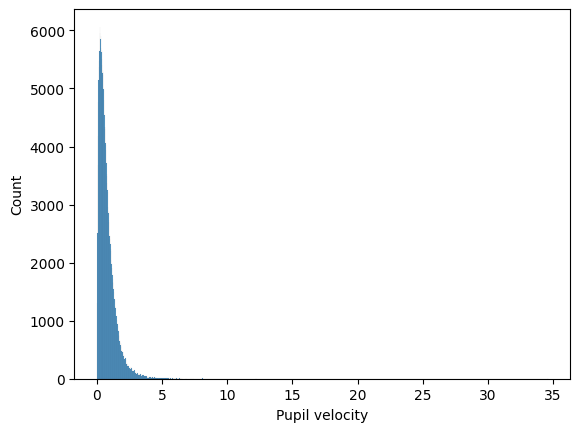

In [15]:
sns.histplot(data=data_df,x='Pupil velocity')

In [16]:
data_df[(data_df['Block']==7)&(data_df['Test']=='a')]

,Unnamed: 0,Trial time datetime,Stim eye - Size Mm,Trial time Sec,Trial no,Trial type,Block,Test,Recording id,Eye,Participant id,Trial phase,Pupil velocity,MAD speed threshold,Time diff,Size diff
185250,185250,-1 days +23:59:59,6.33309,-1.000000,326.0,s,7,a,15,R,201,pre-stim,0.189602,0.828271,NaN,NaN
185251,185251,-1 days +23:59:59.033333334,6.32677,-0.966667,326.0,s,7,a,15,R,201,pre-stim,0.480605,0.828271,0.033333,-0.00632
185252,185252,-1 days +23:59:59.066666668,6.34279,-0.933334,326.0,s,7,a,15,R,201,pre-stim,0.480605,0.828271,0.033333,0.01602
185253,185253,-1 days +23:59:59.100000002,6.35052,-0.900000,326.0,s,7,a,15,R,201,pre-stim,0.231895,0.828271,0.033334,0.00773
185254,185254,-1 days +23:59:59.133333336,6.35220,-0.866667,326.0,s,7,a,15,R,201,pre-stim,0.092401,0.828271,0.033333,0.00168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199495,199495,0 days 00:00:17.833333710,5.98369,17.833333,350.0,lms,7,a,15,R,201,post-stim,1.221612,1.603666,0.033333,-0.04072
199496,199496,0 days 00:00:17.866667044,5.94647,17.866667,350.0,lms,7,a,15,R,201,post-stim,1.116578,1.603666,0.033334,-0.03722
199497,199497,0 days 00:00:17.900000378,5.90930,17.900000,350.0,lms,7,a,15,R,201,post-stim,1.115111,1.603666,0.033333,-0.03717
199498,199498,0 days 00:00:17.933333712,5.87922,17.933333,350.0,lms,7,a,15,R,201,post-stim,0.902409,1.603666,0.033333,-0.03008


In [17]:
def plot_trial_speed_MAD(data_df,trial_no):
    plt.figure(figsize = (30,10))

    plt.plot(data_df['Trial time Sec'][data_df['Trial no']==trial_no],data_df['Pupil velocity'][data_df['Trial no']==trial_no],label='speed mm/s',marker='.',linestyle='none')
    plt.plot(data_df['Trial time Sec'][data_df['Trial no']==trial_no],data_df['Stim eye - Size Mm'][data_df['Trial no']==trial_no],label='size mm',marker='.',linestyle='none')
    plt.plot(data_df['Trial time Sec'][(data_df['Trial no']==trial_no)&(data_df['Pupil velocity']>data_df['MAD speed threshold'])],data_df['Stim eye - Size Mm'][(data_df['Trial no']==trial_no)&(data_df['Pupil velocity']>data_df['MAD speed threshold'])],marker='.',linestyle='none',color='k',label='Removed by MAD')
    plt.plot(data_df['Trial time Sec'][data_df['Trial no']==trial_no],data_df['MAD speed threshold'][data_df['Trial no']==trial_no],label='mad threshold speed mm')

    plt.ylim([0,10])
    plt.grid(which='both')
    plt.minorticks_on()
    plt.legend()
    plt.xlabel('Time [s]')
    plt.show()

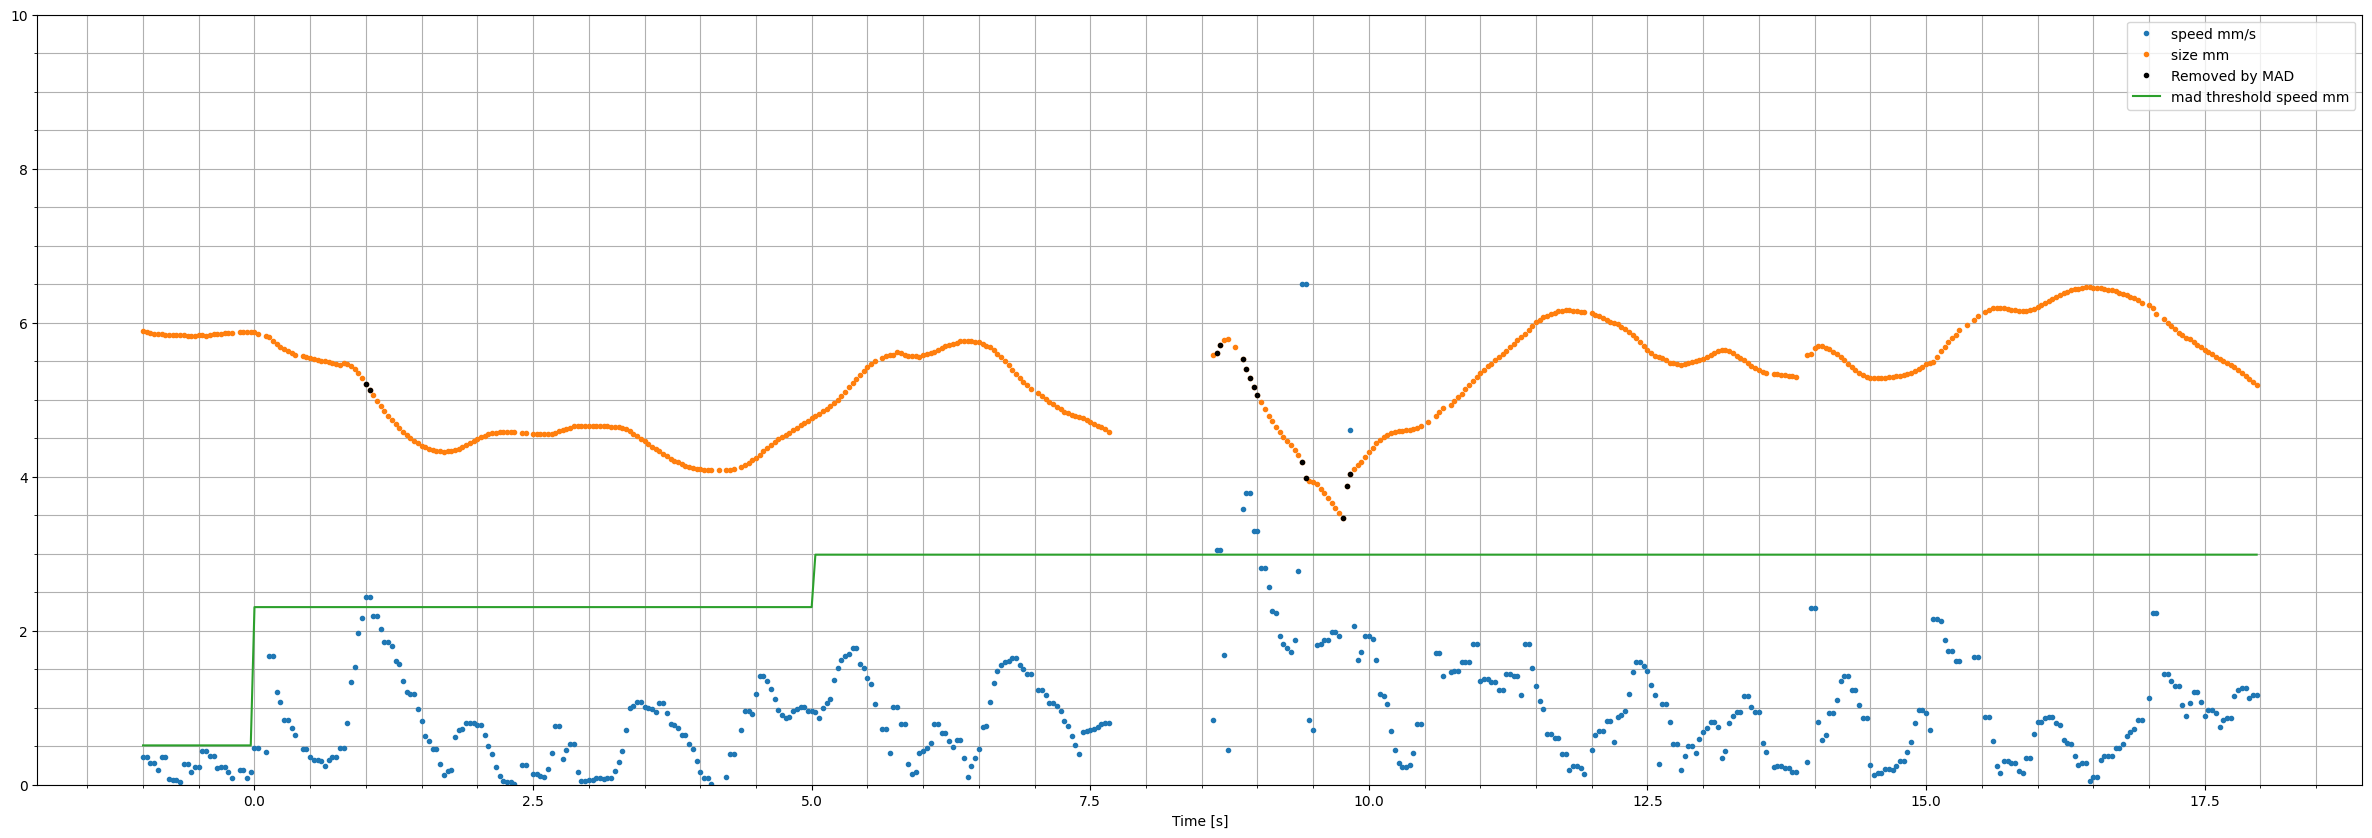

In [18]:
plot_trial_speed_MAD(data_df,355)

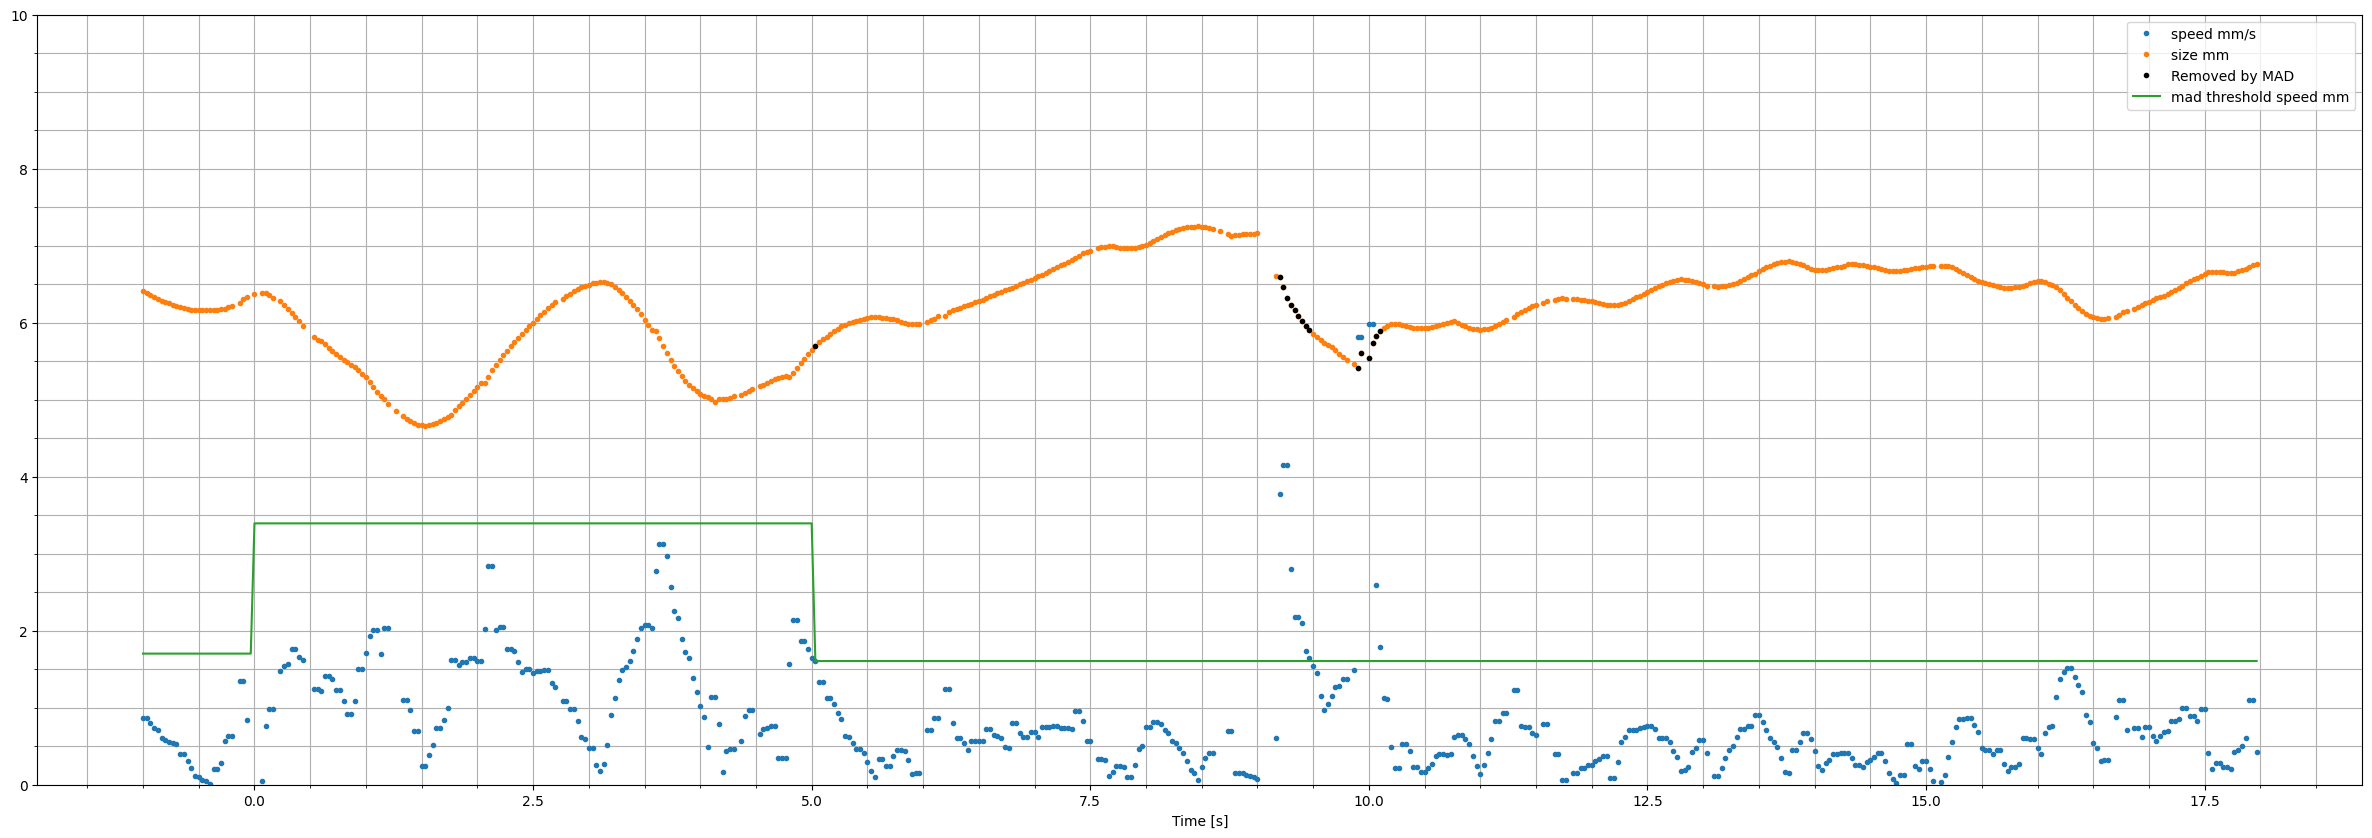

In [19]:
plot_trial_speed_MAD(data_df,120)

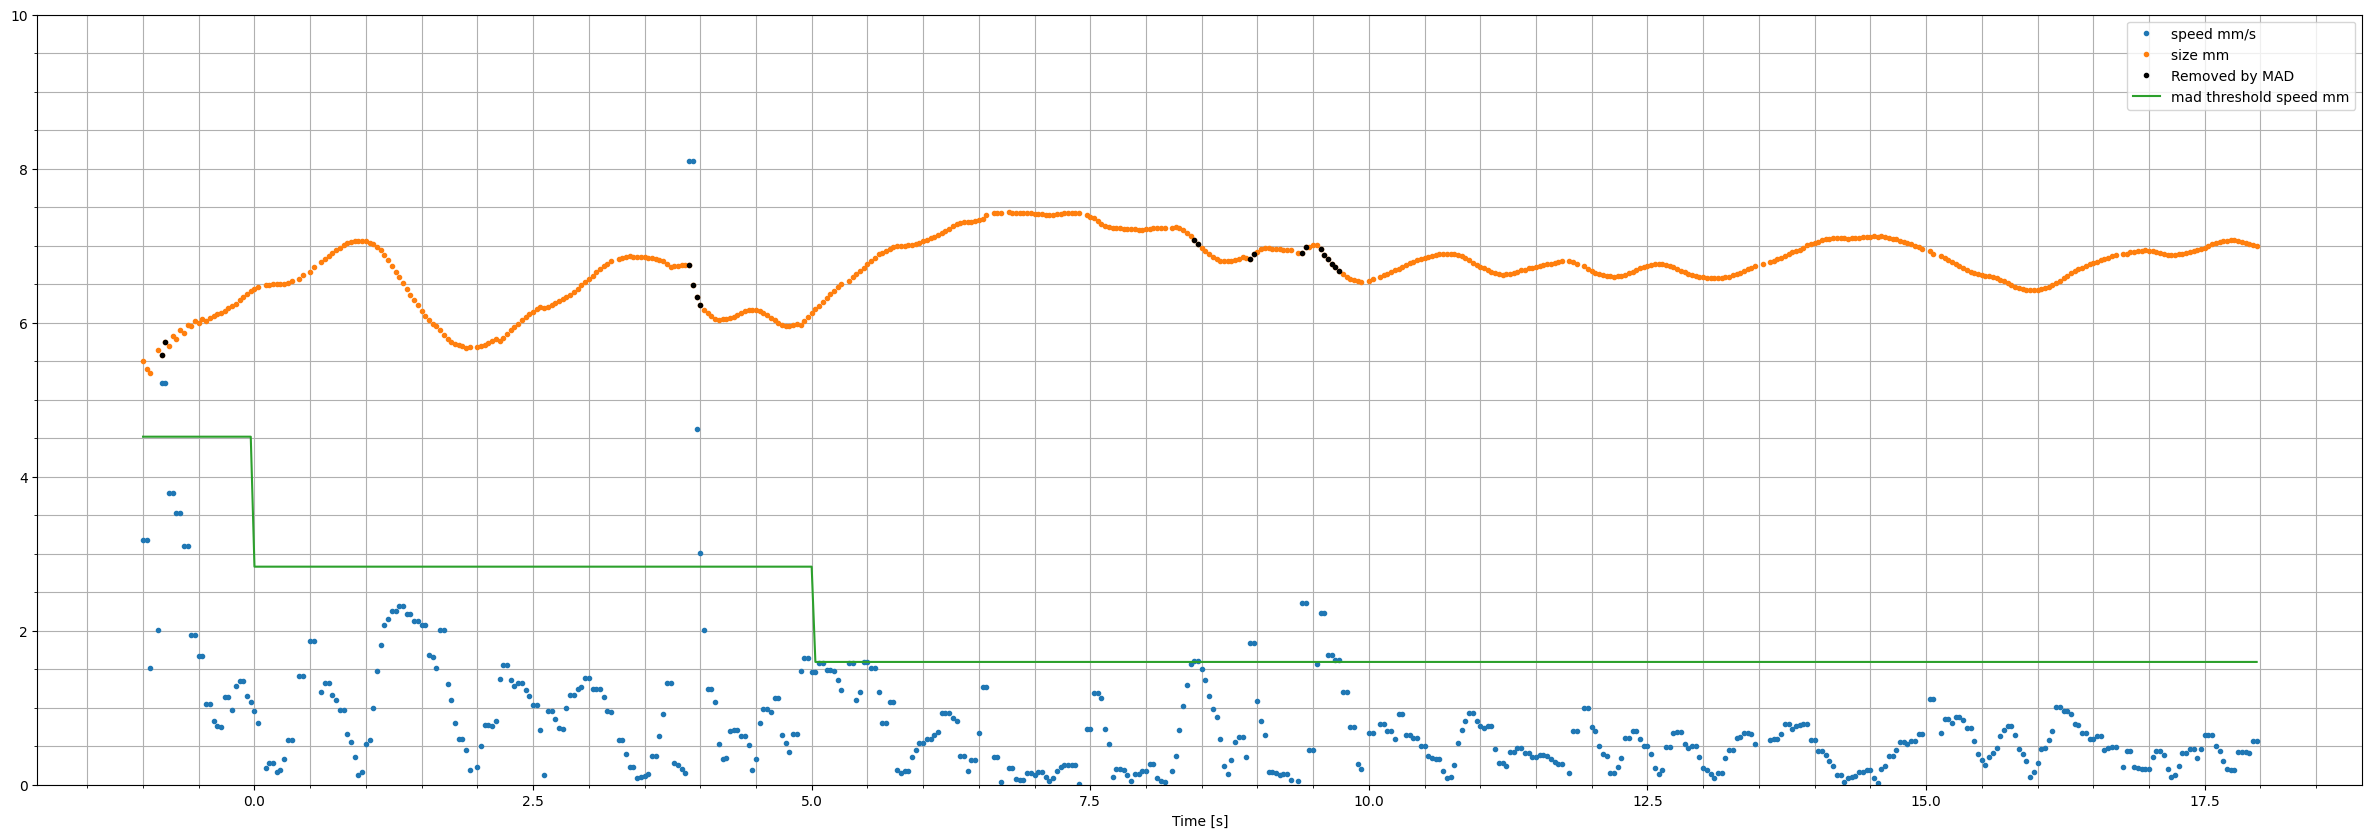

In [20]:
plot_trial_speed_MAD(data_df,20)

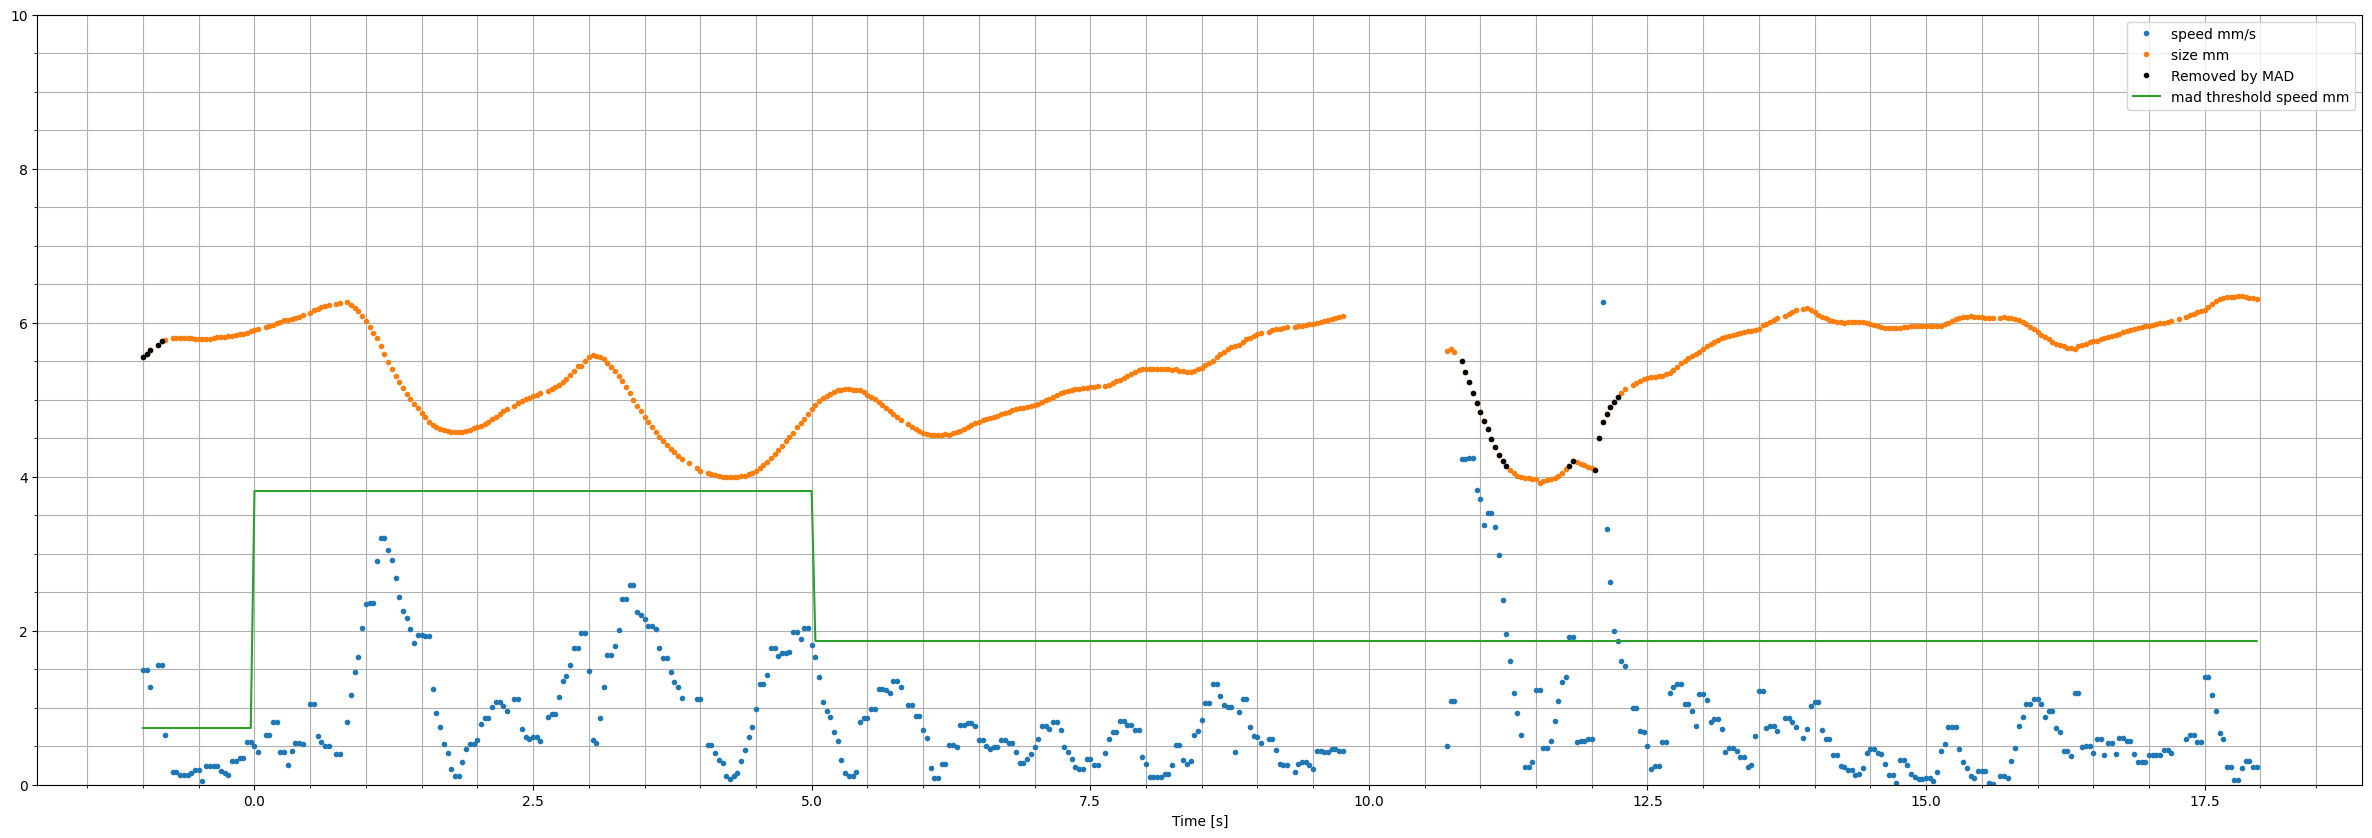

In [21]:
plot_trial_speed_MAD(data_df,435)

As seen in the examples above, the MAD threshold is calculated for each trial phase separately. One problematic area for it is the baseline, where due to a low number of samples, potentially a spike can overtake the whole length of the signal. Usually though spikes like that are shorter in duration. My next proposed step is filtering based on pupil size, which ought to take care of the few flatter spike points, like e.g. can be seen in the second plot. MAD for pupil speed doesn't remove all the points in the spike around 12 s. 

# MAD pupil size filtering

In [22]:
def compute_windowed_size_mad(resampled_df,step,multiplier):

    resampled_df['MAD size threshold'] = pd.Series()
    for trial_no in sorted(resampled_df['Trial no'].unique()):
        trial = resampled_df[resampled_df['Trial no']==trial_no].copy(deep=True)
        trial.reset_index(inplace=True)
        trial['MAD size threshold'] = pd.Series()
        steps = np.arange(0,len(trial),step)
        for i,st in enumerate(steps):
            if i != len(steps)-1:
                median = trial.loc[steps[i]:steps[i+1],'Stim eye - Size Mm'].median()
                mad = (abs(trial.loc[steps[i]:steps[i]+step,'Stim eye - Size Mm'] - median)).median()
                trial.loc[steps[i]:steps[i]+step,'MAD size upper threshold']=median+multiplier*mad
                trial.loc[steps[i]:steps[i]+step,'MAD size lower threshold']=median-multiplier*mad
            else:
                median = trial.loc[steps[i]::,'Stim eye - Size Mm'].median()
                mad = (abs(trial.loc[steps[i]::,'Stim eye - Size Mm'] - median)).median()
                trial.loc[steps[i]::,'MAD size upper threshold']=median+multiplier*mad
                trial.loc[steps[i]:steps[i]+step,'MAD size lower threshold']=median-multiplier*mad
        
        resampled_df.loc[resampled_df['Trial no']==trial_no,'MAD size upper threshold'] = trial['MAD size upper threshold'].to_list()
        resampled_df.loc[resampled_df['Trial no']==trial_no,'MAD size lower threshold'] = trial['MAD size lower threshold'].to_list()

    return resampled_df